In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import re
from sqlalchemy import create_engine

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM "corrected_merged_claim_data_EF";'
data = pd.read_sql(query, con=engine)

selected_columns = ['Policy No', 'Renewal Type', 'Product name ', 'Product name  2', 'biztype', 'Policy End Date', 'Policy Start Date', 'Reg no ', 
                    'age', 'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ', 'Vehicle IDV', 'NCB Amount', 
                    'Before GST Add-on GWP', 'Total OD Premium', 'Total TP Premium', 'gst', 'Total Premium Payable ', 'NCB % Previous Year', 
                    'Vehicle Segment', 'Applicable Discount with NCB', 'Tie Up', 'Cleaned_Insured name', 'Cleaned_New Branch Name 2', 
                    'Cleaned_state2', 'Zone 2', 'Number of claims', 'Approved', 'Denied', 'CustomerID', 'Policy Status', 'Policy Tenure', 
                    'Customer Tenure', 'New Customers', 'Claim Happaned/Not', 'Renewal Rate Status']

data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Identify numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()

# Outlier removal using IQR method (fixed)
def remove_outliers(df, num_cols):
    Q1 = df[num_cols].quantile(0.25)
    Q3 = df[num_cols].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df.loc[~((df[num_cols] < lower_bound) | (df[num_cols] > upper_bound)).any(axis=1)]

# Apply outlier removal
data = remove_outliers(data, numerical_cols)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

# Split the data into train and test sets (80% train, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [2]:
# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_count = X_train.value_counts()
test_count = X_test.value_counts()

train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

print("Training Data Counts:")
print(train_count)

print("\nTesting Data Counts:")
print(test_count)

print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Training Data Counts:
Policy No                  Renewal Type  Product name                                  Product name  2  biztype           Reg no          age        MANUFACTURER/Make  model      variant                         Fuel Type  RTO Location   Vehicle IDV  NCB Amount   Before GST Add-on GWP  Total OD Premium  Total TP Premium  gst     Total Premium Payable   NCB % Previous Year  Vehicle Segment  Applicable Discount with NCB  Tie Up   Cleaned_Insured name      Cleaned_New Branch Name 2  Cleaned_state2  Zone 2  Number of claims  Approved  Denied  CustomerID  Policy Tenure  Customer Tenure  New Customers  Claim Happaned/Not  Renewal Rate Status  Policy Start Date_YEAR  Policy Start Date_MONTH  Policy Start Date_DAY  Policy End Date_YEAR  Policy End Date_MONTH  Policy End Date_DAY
'201110000020700752300000  missing       PrivateCarPolicy                              missing          Roll Over         DL-08-CAT-5467  2.940000   MARUTI             BALENO     DELTA 1.2         

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [4]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

Test Accuracy: 0.7163841866066879
Test Log Loss: 0.5424305296051611
Test ROC AUC: 0.7608216987873071
Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.61      0.57     60507
           1       0.81      0.77      0.79    133784

    accuracy                           0.72    194291
   macro avg       0.68      0.69      0.68    194291
weighted avg       0.73      0.72      0.72    194291

Class 0 Test Accuracy: 0.6087560117011255
Class 1 Test Accuracy: 0.7650615918196496
Train Accuracy: 0.7473959793248046
Train Log Loss: 0.48677528385992924
Train ROC AUC: 0.8295081437791831
Train Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.73      0.74    535134
           1       0.74      0.76      0.75    535134

    accuracy                           0.75   1070268
   macro avg       0.75      0.75      0.75   1070268
weighted avg       0.75      0.75      0.75   1070268


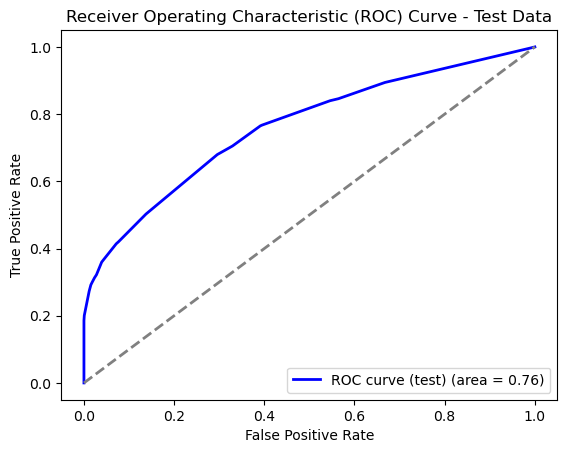

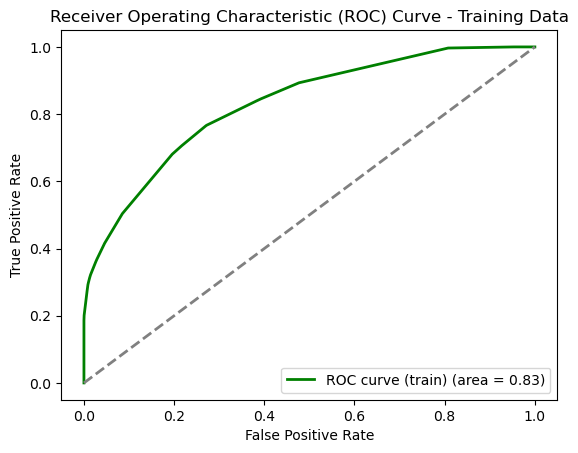

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=5)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7271309530549537
Test Log Loss: 0.9091172277486077
Test ROC AUC: 0.7931962072661654
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.68      0.61     60507
           1       0.84      0.75      0.79    133784

    accuracy                           0.73    194291
   macro avg       0.69      0.71      0.70    194291
weighted avg       0.75      0.73      0.73    194291

Class 0 Test Accuracy: 0.680946006247211
Class 1 Test Accuracy: 0.7480191951204928
Train Accuracy: 0.7919446344280124
Train Log Loss: 0.4002873092468813
Train ROC AUC: 0.8881202648260695
Train Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    535134
           1       0.81      0.77      0.79    535134

    accuracy                           0.79   1070268
   macro avg       0.79      0.79      0.79   1070268
weighted avg       0.79      0.79      0.79   1070268

C

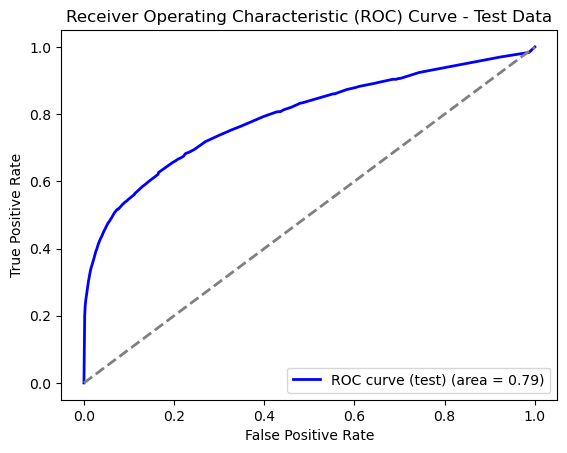

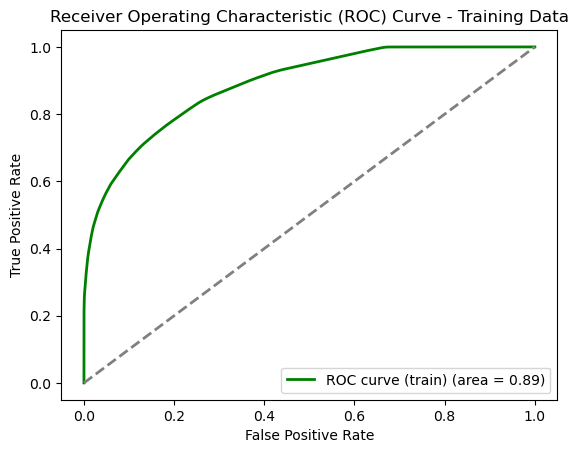

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=10)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6385370398011231
Test Log Loss: 12.995948478782799
Test ROC AUC: 0.6054060570922026
Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.52      0.47     60507
           1       0.76      0.69      0.73    133784

    accuracy                           0.64    194291
   macro avg       0.60      0.61      0.60    194291
weighted avg       0.66      0.64      0.65    194291

Class 0 Test Accuracy: 0.5199233146578082
Class 1 Test Accuracy: 0.692182921724571
Train Accuracy: 0.998521865551432
Train Log Loss: 0.003568831889171241
Train ROC AUC: 0.9999909776811322
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268



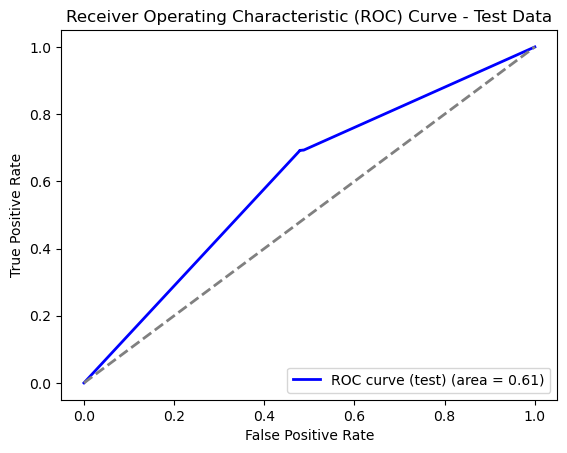

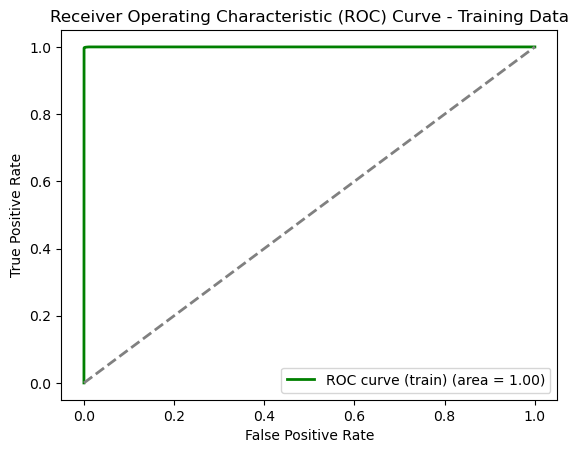

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=40)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6295762541754378
Test Log Loss: 8.85378669481875
Test ROC AUC: 0.6301405019811855
Test Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.53      0.47     60507
           1       0.76      0.67      0.71    133784

    accuracy                           0.63    194291
   macro avg       0.59      0.60      0.59    194291
weighted avg       0.66      0.63      0.64    194291

Class 0 Test Accuracy: 0.5342522352785628
Class 1 Test Accuracy: 0.6726888118160617
Train Accuracy: 0.9560913715069497
Train Log Loss: 0.08419452292521495
Train ROC AUC: 0.995059278802763
Train Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    535134
           1       0.96      0.95      0.96    535134

    accuracy                           0.96   1070268
   macro avg       0.96      0.96      0.96   1070268
weighted avg       0.96      0.96      0.96   1070268

Cl

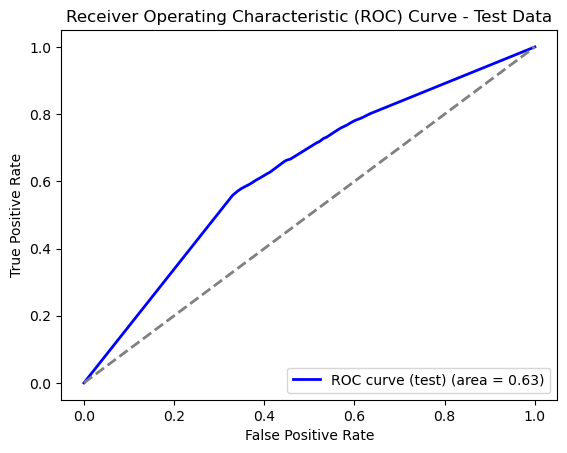

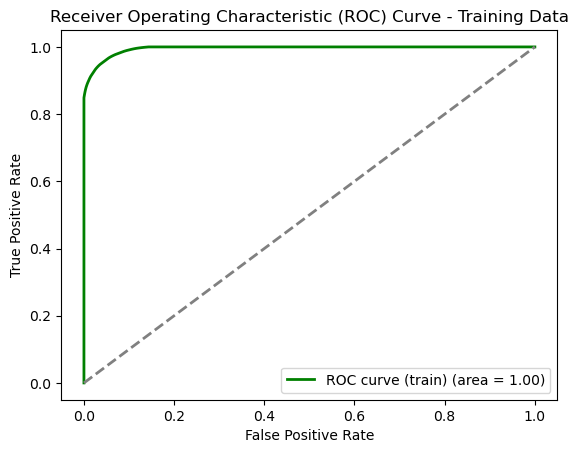

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, min_samples_split=10)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6881996592739756
Test Log Loss: 5.118711356241975
Test ROC AUC: 0.6949017443382584
Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.54      0.52     60507
           1       0.78      0.75      0.77    133784

    accuracy                           0.69    194291
   macro avg       0.64      0.65      0.64    194291
weighted avg       0.70      0.69      0.69    194291

Class 0 Test Accuracy: 0.5428793362751417
Class 1 Test Accuracy: 0.7539242360820427
Train Accuracy: 0.9305099283543935
Train Log Loss: 0.13533728185494254
Train ROC AUC: 0.9872109721790505
Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93    535134
           1       0.93      0.93      0.93    535134

    accuracy                           0.93   1070268
   macro avg       0.93      0.93      0.93   1070268
weighted avg       0.93      0.93      0.93   1070268



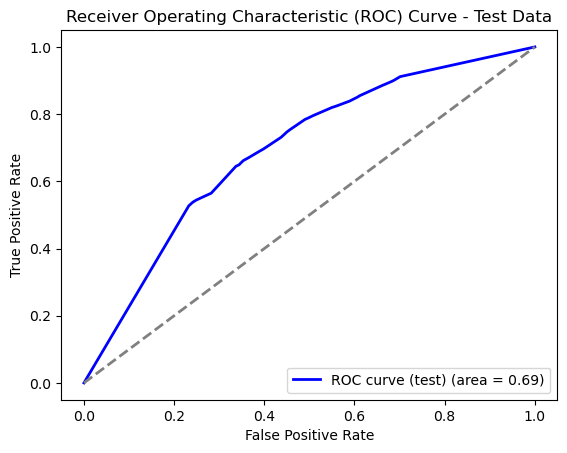

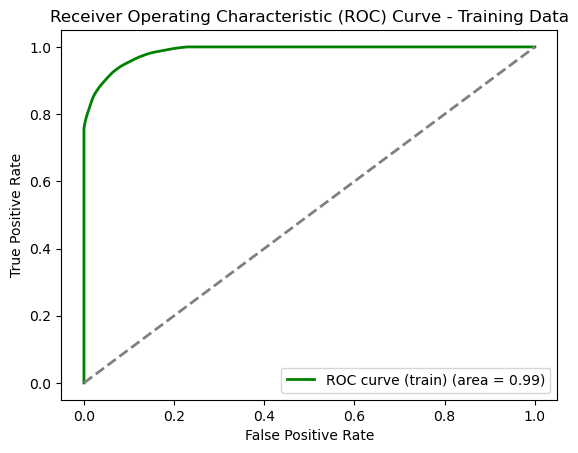

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, min_samples_leaf=5)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6557946585276724
Test Log Loss: 12.406418022711286
Test ROC AUC: 0.6276186855328686
Test Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50     60507
           1       0.78      0.70      0.74    133784

    accuracy                           0.66    194291
   macro avg       0.62      0.63      0.62    194291
weighted avg       0.68      0.66      0.66    194291

Class 0 Test Accuracy: 0.5529112334110103
Class 1 Test Accuracy: 0.7023261376547271
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

Class 0 Train Accuracy: 1.

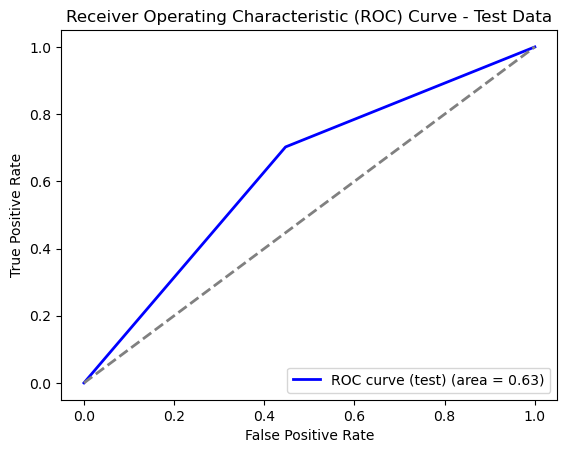

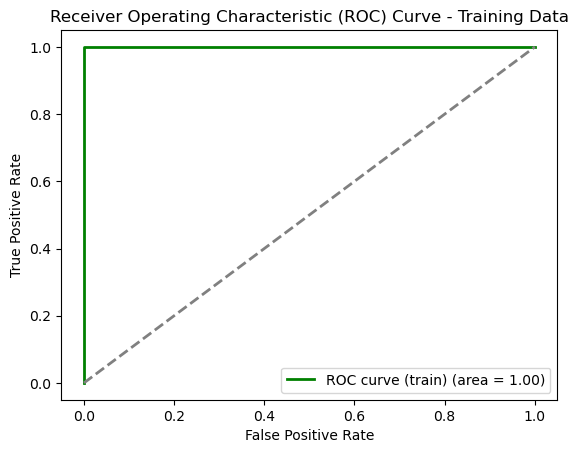

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_features='sqrt')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.688318038406308
Test Log Loss: 11.234156591323154
Test ROC AUC: 0.6395803040747313
Test Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50     60507
           1       0.78      0.77      0.77    133784

    accuracy                           0.69    194291
   macro avg       0.64      0.64      0.64    194291
weighted avg       0.69      0.69      0.69    194291

Class 0 Test Accuracy: 0.510354173897235
Class 1 Test Accuracy: 0.7688064342522275
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

Class 0 Train Accuracy: 1.0


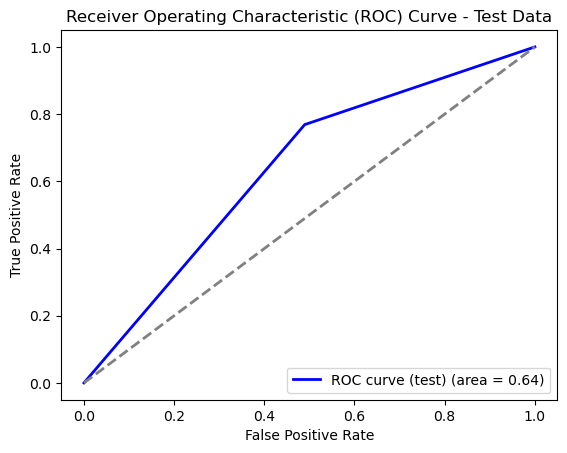

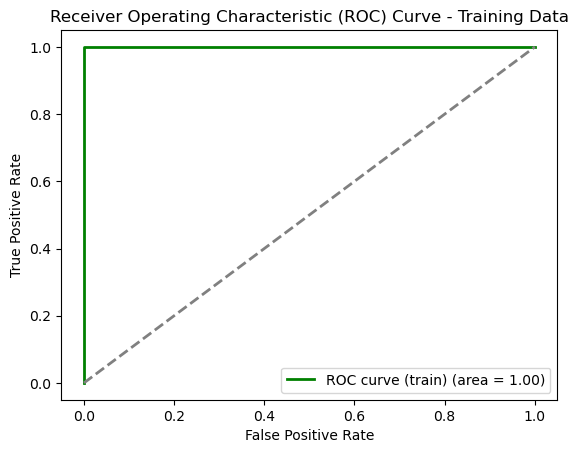

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, criterion='entropy')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6337504053198553
Test Log Loss: 13.20097344455578
Test ROC AUC: 0.6007533322139872
Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.51      0.47     60507
           1       0.76      0.69      0.72    133784

    accuracy                           0.63    194291
   macro avg       0.59      0.60      0.59    194291
weighted avg       0.65      0.63      0.64    194291

Class 0 Test Accuracy: 0.5132629282562348
Class 1 Test Accuracy: 0.6882437361717395
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

Class 0 Train Accuracy: 1.0

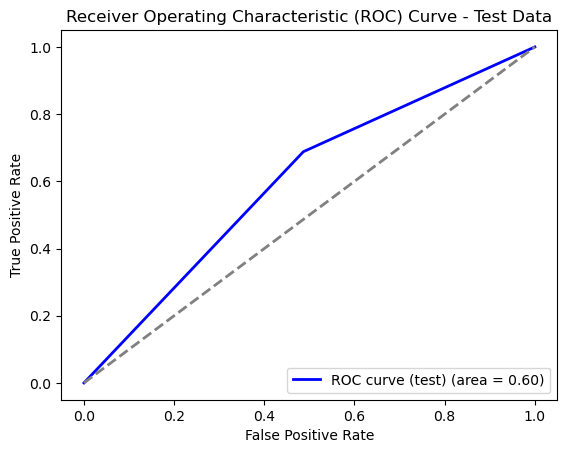

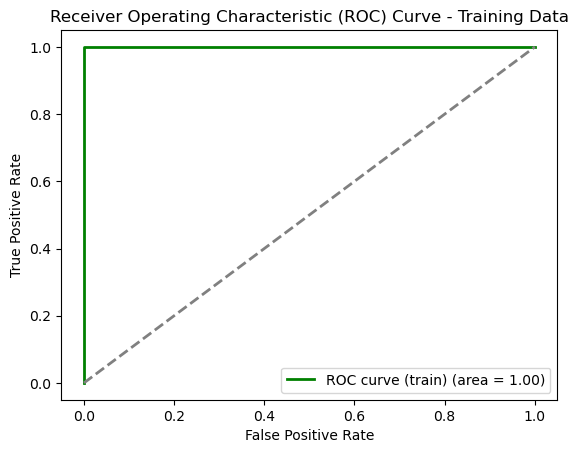

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7271309530549537
Test Log Loss: 0.9091172277486077
Test ROC AUC: 0.7931962072661654
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.68      0.61     60507
           1       0.84      0.75      0.79    133784

    accuracy                           0.73    194291
   macro avg       0.69      0.71      0.70    194291
weighted avg       0.75      0.73      0.73    194291

Class 0 Test Accuracy: 0.680946006247211
Class 1 Test Accuracy: 0.7480191951204928
Train Accuracy: 0.7919446344280124
Train Log Loss: 0.4002873092468813
Train ROC AUC: 0.8881202648260695
Train Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    535134
           1       0.81      0.77      0.79    535134

    accuracy                           0.79   1070268
   macro avg       0.79      0.79      0.79   1070268
weighted avg       0.79      0.79      0.79   1070268

C

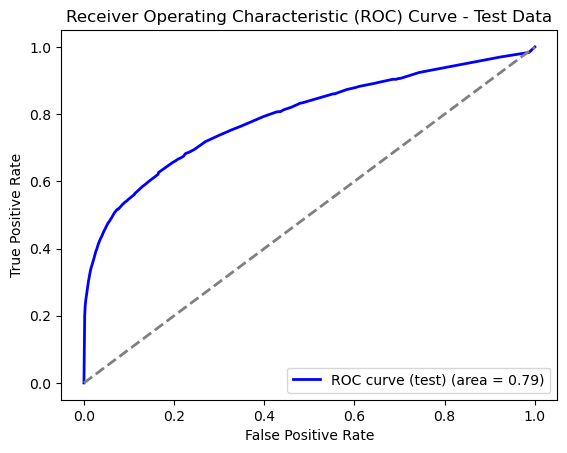

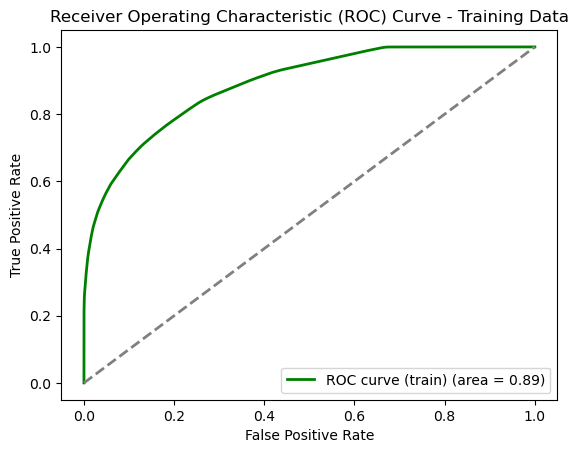

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7242486785285989
Test Log Loss: 0.5347280218499886
Test ROC AUC: 0.768072633634119
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.60      0.58     60507
           1       0.81      0.78      0.80    133784

    accuracy                           0.72    194291
   macro avg       0.68      0.69      0.69    194291
weighted avg       0.73      0.72      0.73    194291

Class 0 Test Accuracy: 0.5995174112086205
Class 1 Test Accuracy: 0.7806613645876936
Train Accuracy: 0.7538224070980353
Train Log Loss: 0.4730263428488591
Train ROC AUC: 0.8409686513628596
Train Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75    535134
           1       0.74      0.78      0.76    535134

    accuracy                           0.75   1070268
   macro avg       0.75      0.75      0.75   1070268
weighted avg       0.75      0.75      0.75   1070268

C

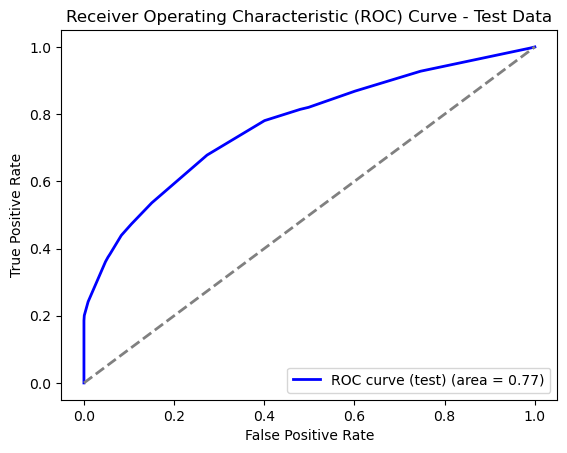

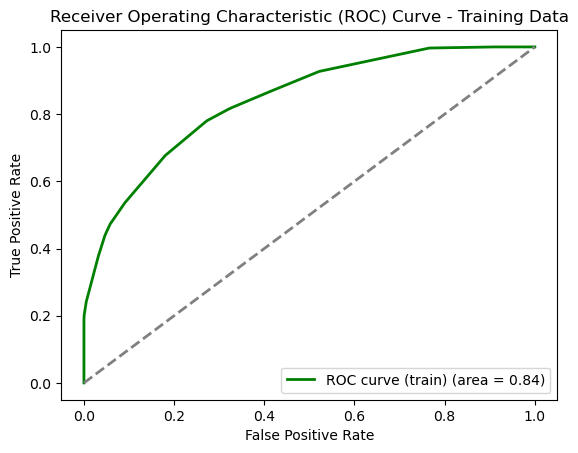

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_leaf_nodes=20)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6834953754934608
Test Log Loss: 11.407982981766374
Test ROC AUC: 0.6534451859028152
Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.57      0.53     60507
           1       0.79      0.73      0.76    133784

    accuracy                           0.68    194291
   macro avg       0.64      0.65      0.65    194291
weighted avg       0.70      0.68      0.69    194291

Class 0 Test Accuracy: 0.573768324326111
Class 1 Test Accuracy: 0.7331220474795193
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

Class 0 Train Accuracy: 1.0

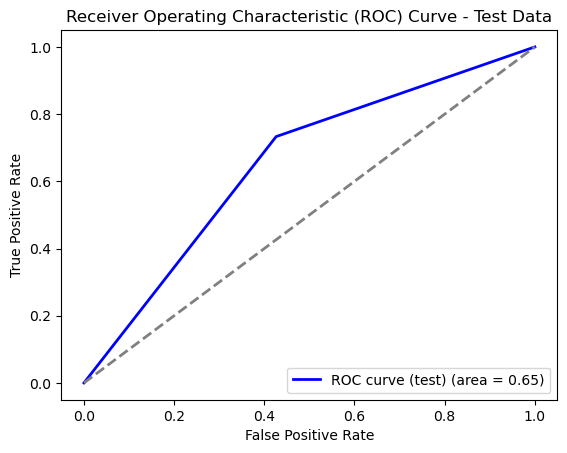

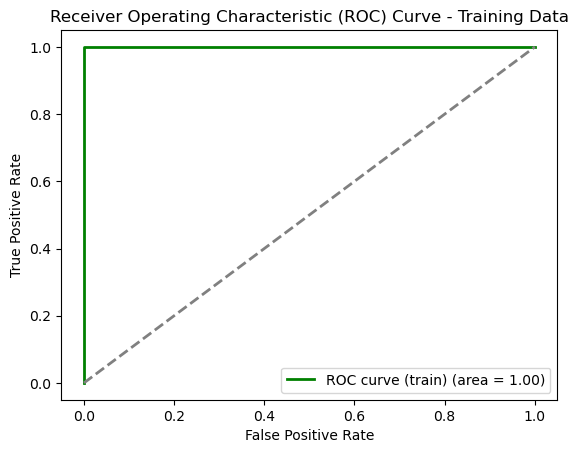

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, splitter='random')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6337504053198553
Test Log Loss: 13.20097344455578
Test ROC AUC: 0.6007533322139872
Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.51      0.47     60507
           1       0.76      0.69      0.72    133784

    accuracy                           0.63    194291
   macro avg       0.59      0.60      0.59    194291
weighted avg       0.65      0.63      0.64    194291

Class 0 Test Accuracy: 0.5132629282562348
Class 1 Test Accuracy: 0.6882437361717395
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

Class 0 Train Accuracy: 1.0

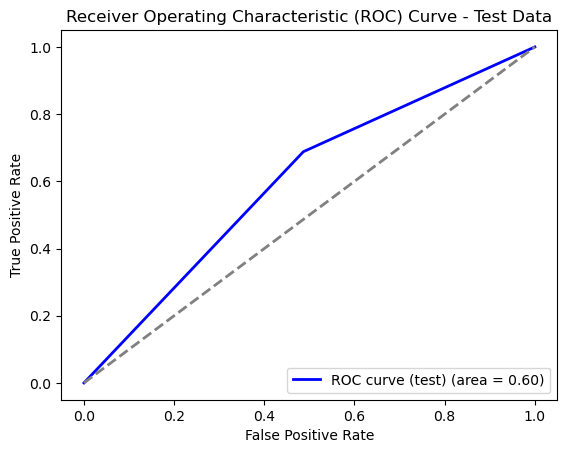

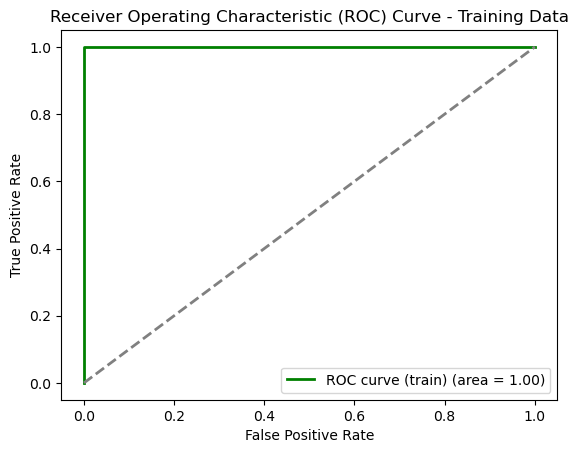

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7106711067419489
Test Log Loss: 0.5967301488970159
Test ROC AUC: 0.699461166156502
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.35      0.43     60507
           1       0.75      0.87      0.81    133784

    accuracy                           0.71    194291
   macro avg       0.65      0.61      0.62    194291
weighted avg       0.69      0.71      0.69    194291

Class 0 Test Accuracy: 0.351876642371957
Class 1 Test Accuracy: 0.8729444477665491
Train Accuracy: 0.7024857325454933
Train Log Loss: 0.5494444620440747
Train ROC AUC: 0.7692608880269933
Train Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.53      0.64    535134
           1       0.65      0.87      0.75    535134

    accuracy                           0.70   1070268
   macro avg       0.73      0.70      0.69   1070268
weighted avg       0.73      0.70      0.69   1070268

Cl

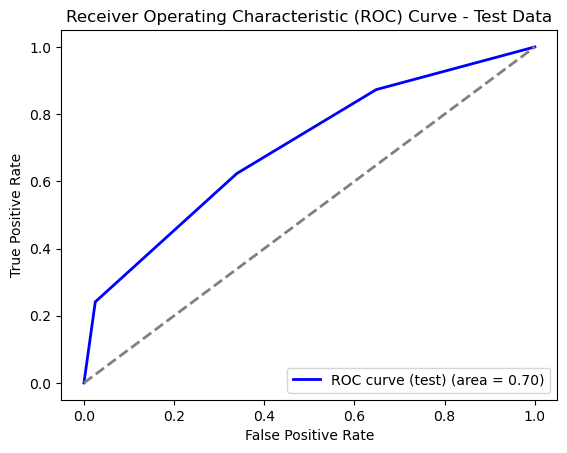

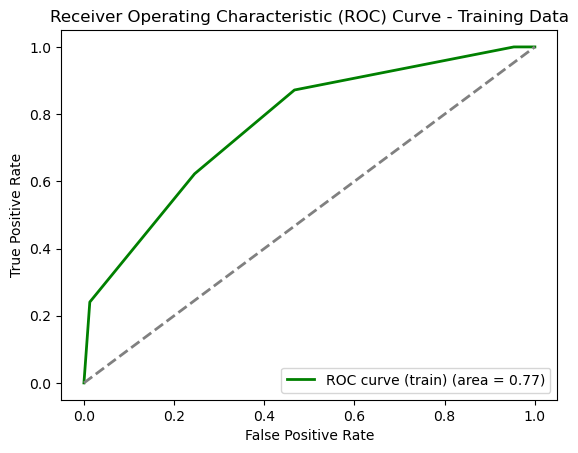

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,                
    min_samples_split=20,       
    min_samples_leaf=10,        
    max_leaf_nodes=50,          
    ccp_alpha=0.01              
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7464010170311542
Test Log Loss: 0.48753999272049175
Test ROC AUC: 0.8212137913487495
Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.70      0.63     60507
           1       0.85      0.77      0.81    133784

    accuracy                           0.75    194291
   macro avg       0.71      0.73      0.72    194291
weighted avg       0.76      0.75      0.75    194291

Class 0 Test Accuracy: 0.6996545854198688
Class 1 Test Accuracy: 0.7675432039705794
Train Accuracy: 0.8089824230940288
Train Log Loss: 0.41611313237657255
Train ROC AUC: 0.9005003729780339
Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.84      0.82    535134
           1       0.83      0.77      0.80    535134

    accuracy                           0.81   1070268
   macro avg       0.81      0.81      0.81   1070268
weighted avg       0.81      0.81      0.81   1070268

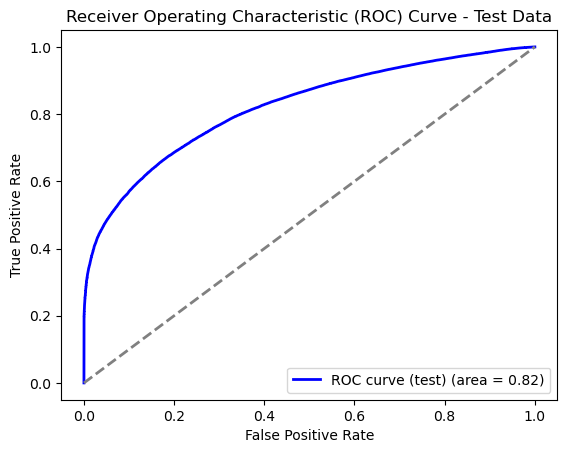

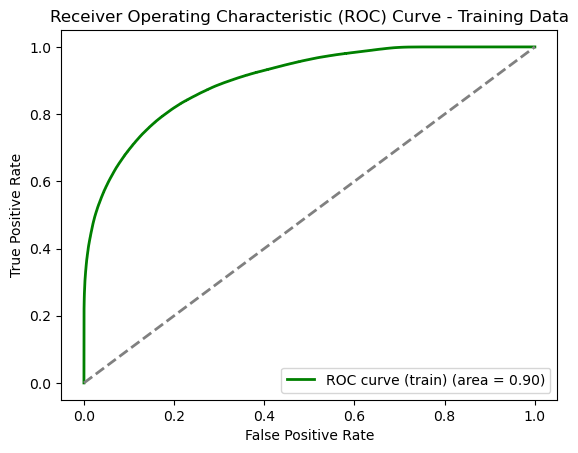

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=10)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.49139692523071066
Test Log Loss: 1.0854012937340316
Test ROC AUC: 0.8100630307608773
Test Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55     60507
           1       1.00      0.26      0.42    133784

    accuracy                           0.49    194291
   macro avg       0.69      0.63      0.48    194291
weighted avg       0.80      0.49      0.46    194291

Class 0 Test Accuracy: 0.9975870560431025
Class 1 Test Accuracy: 0.26246038390240983
Train Accuracy: 0.6353408678947703
Train Log Loss: 0.815171599948896
Train ROC AUC: 0.8703235033646912
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73    535134
           1       0.99      0.27      0.43    535134

    accuracy                           0.64   1070268
   macro avg       0.79      0.64      0.58   1070268
weighted avg       0.79      0.64      0.58   1070268


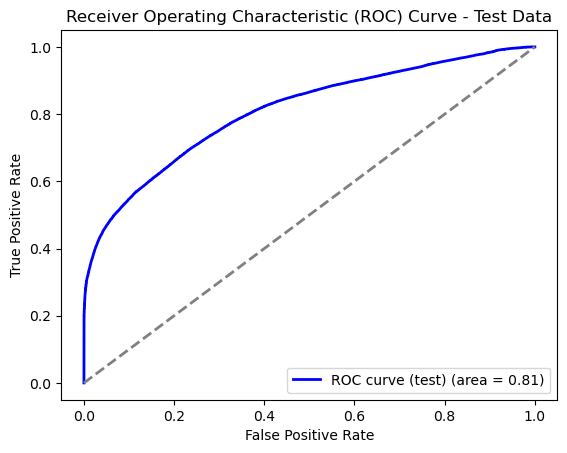

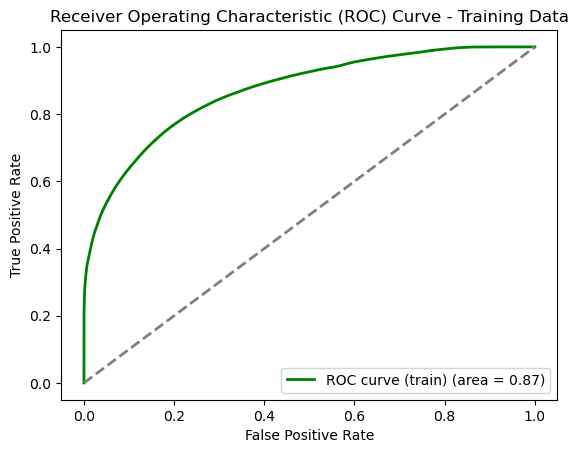

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 10, 1: 1},  
    random_state=42
)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7745803974450695
Test Log Loss: 0.45877407083549365
Test ROC AUC: 0.8450444988254637
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.67      0.65     60507
           1       0.85      0.82      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.74      0.75      0.74    194291
weighted avg       0.78      0.77      0.78    194291

Class 0 Test Accuracy: 0.6693605698514221
Class 1 Test Accuracy: 0.8221685702326138
Train Accuracy: 0.8545364338651628
Train Log Loss: 0.3328946814601429
Train ROC AUC: 0.9408112497835592
Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86    535134
           1       0.87      0.84      0.85    535134

    accuracy                           0.85   1070268
   macro avg       0.85      0.85      0.85   1070268
weighted avg       0.85      0.85      0.85   1070268


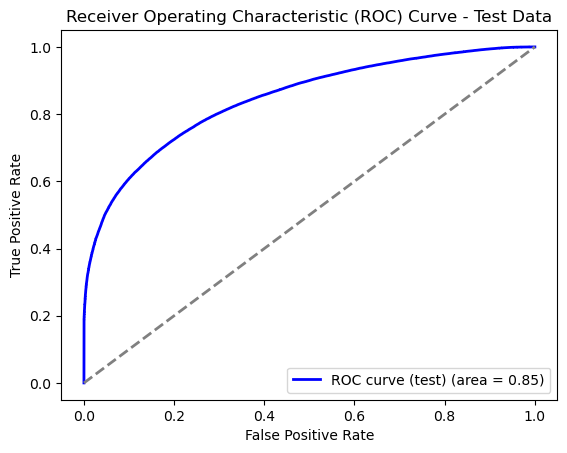

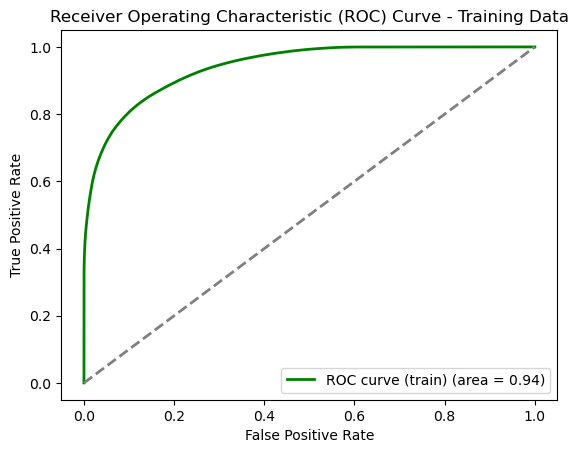

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=16)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.773880416488669
Test Log Loss: 0.460816301116232
Test ROC AUC: 0.8449393170672594
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65     60507
           1       0.84      0.82      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.74      0.74      0.74    194291
weighted avg       0.78      0.77      0.78    194291

Class 0 Test Accuracy: 0.6642702497231725
Class 1 Test Accuracy: 0.8234542247204449
Train Accuracy: 0.8648245112439127
Train Log Loss: 0.31738692635837085
Train ROC AUC: 0.9483524054589555
Train Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.88      0.87    535134
           1       0.88      0.85      0.86    535134

    accuracy                           0.86   1070268
   macro avg       0.87      0.86      0.86   1070268
weighted avg       0.87      0.86      0.86   1070268

C

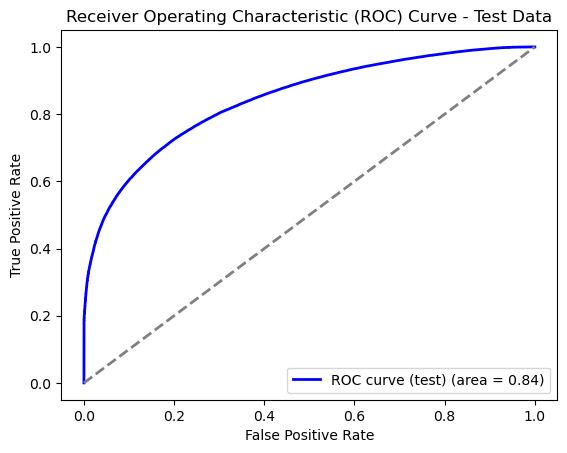

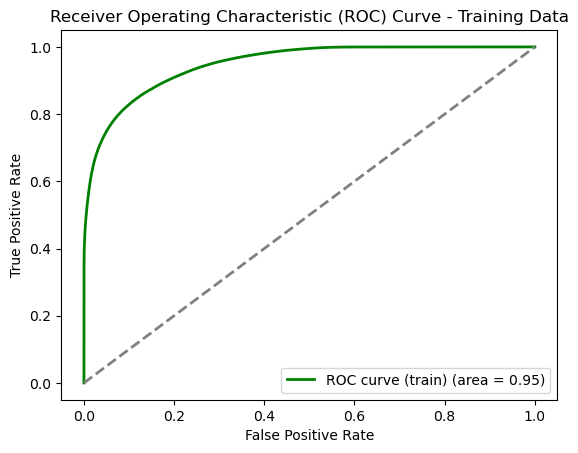

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=17)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7774112027834537
Test Log Loss: 0.4604954713819178
Test ROC AUC: 0.8474309694060098
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64     60507
           1       0.84      0.84      0.84    133784

    accuracy                           0.78    194291
   macro avg       0.74      0.74      0.74    194291
weighted avg       0.78      0.78      0.78    194291

Class 0 Test Accuracy: 0.646338440180475
Class 1 Test Accuracy: 0.8366919811038689
Train Accuracy: 0.9063346750533511
Train Log Loss: 0.2625981880647364
Train ROC AUC: 0.9726675225308812
Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91    535134
           1       0.92      0.89      0.90    535134

    accuracy                           0.91   1070268
   macro avg       0.91      0.91      0.91   1070268
weighted avg       0.91      0.91      0.91   1070268

C

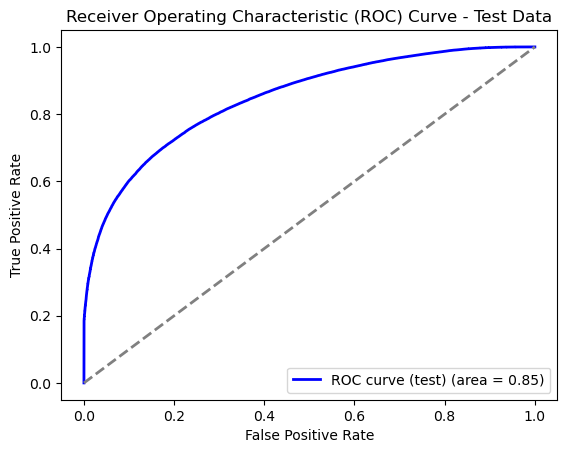

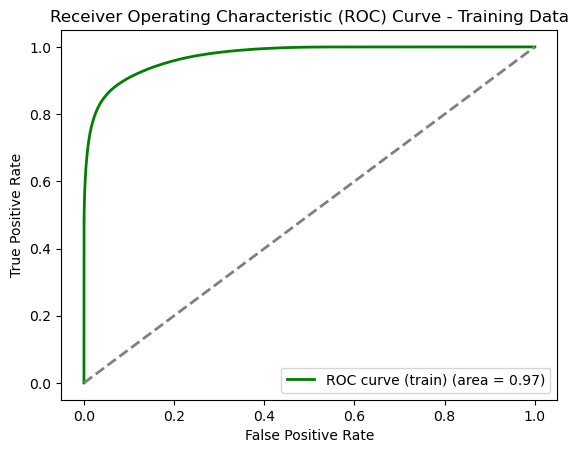

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=20, class_weight='balanced')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7770045961984858
Test Log Loss: 0.4604198516277441
Test ROC AUC: 0.8471504891235486
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65     60507
           1       0.84      0.83      0.84    133784

    accuracy                           0.78    194291
   macro avg       0.74      0.74      0.74    194291
weighted avg       0.78      0.78      0.78    194291

Class 0 Test Accuracy: 0.6541226634934801
Class 1 Test Accuracy: 0.832580876636967
Train Accuracy: 0.8911552994203321
Train Log Loss: 0.28177766832415385
Train ROC AUC: 0.9645592488733364
Train Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89    535134
           1       0.91      0.87      0.89    535134

    accuracy                           0.89   1070268
   macro avg       0.89      0.89      0.89   1070268
weighted avg       0.89      0.89      0.89   1070268



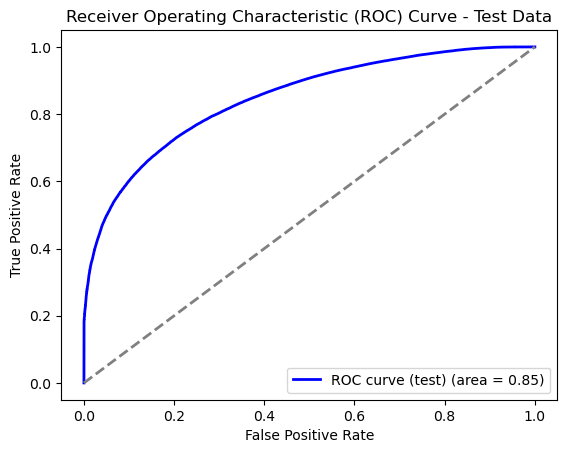

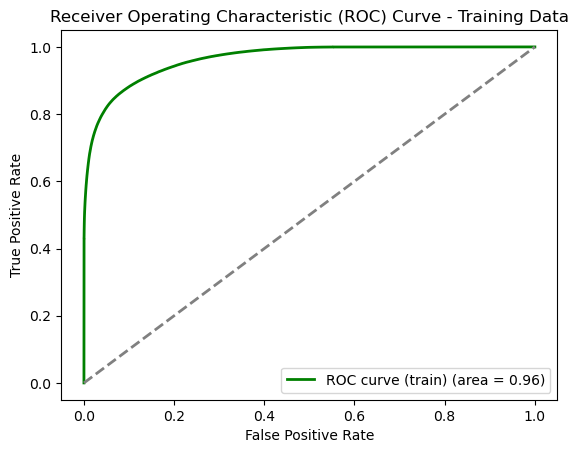

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=19, class_weight='balanced')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7798148138616817
Test Log Loss: 0.46285315244161873
Test ROC AUC: 0.8451557297863294
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.62      0.64     60507
           1       0.83      0.85      0.84    133784

    accuracy                           0.78    194291
   macro avg       0.74      0.74      0.74    194291
weighted avg       0.78      0.78      0.78    194291

Class 0 Test Accuracy: 0.616474126960517
Class 1 Test Accuracy: 0.8536895293906596
Train Accuracy: 0.9680696797437651
Train Log Loss: 0.17317473356428784
Train ROC AUC: 0.9963518590268451
Train Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    535134
           1       0.98      0.95      0.97    535134

    accuracy                           0.97   1070268
   macro avg       0.97      0.97      0.97   1070268
weighted avg       0.97      0.97      0.97   1070268


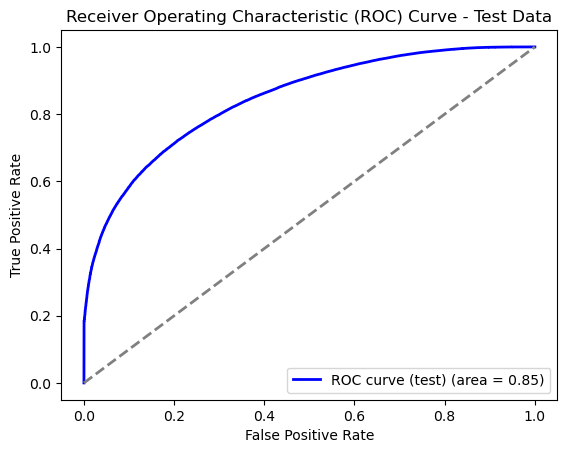

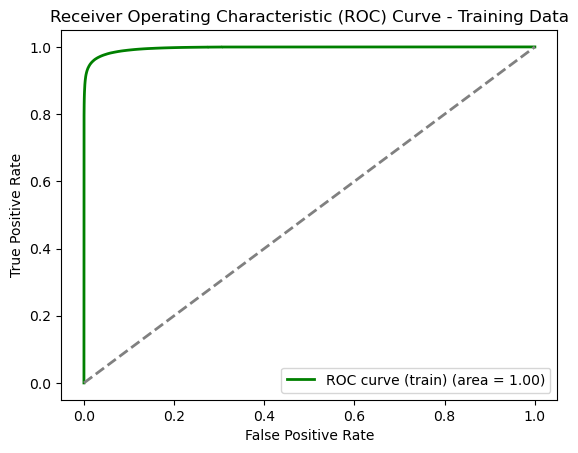

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, max_depth=25, class_weight='balanced')

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7771229753308182
Test Log Loss: 0.46867278916426586
Test ROC AUC: 0.8403770883473307
Test Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.59      0.62     60507
           1       0.82      0.86      0.84    133784

    accuracy                           0.78    194291
   macro avg       0.74      0.73      0.73    194291
weighted avg       0.77      0.78      0.77    194291

Class 0 Test Accuracy: 0.5946419422546152
Class 1 Test Accuracy: 0.8596543682353645
Train Accuracy: 0.9999943939275022
Train Log Loss: 0.09288048019782252
Train ROC AUC: 0.9999999999161919
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    535134
           1       1.00      1.00      1.00    535134

    accuracy                           1.00   1070268
   macro avg       1.00      1.00      1.00   1070268
weighted avg       1.00      1.00      1.00   1070268

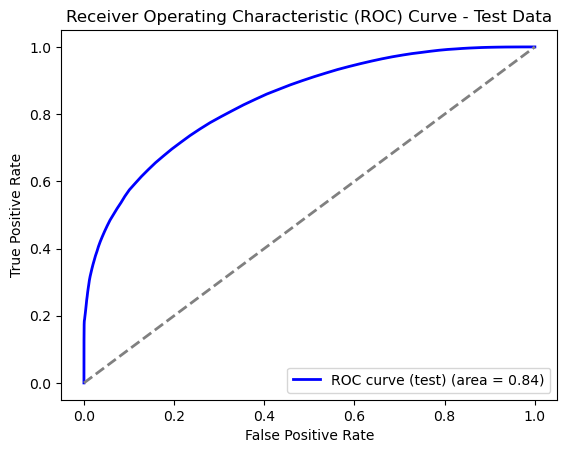

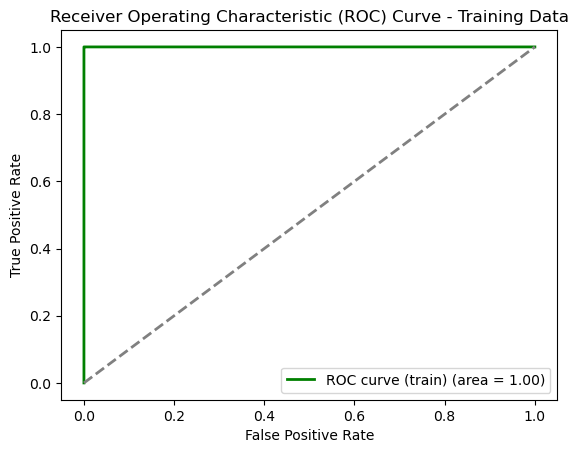

In [25]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = RandomForestClassifier(random_state=42)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5214446371679594
Test Log Loss: 0.8609829318565466
Test ROC AUC: 0.8034559581346469
Test Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.99      0.56     60507
           1       0.99      0.31      0.47    133784

    accuracy                           0.52    194291
   macro avg       0.69      0.65      0.52    194291
weighted avg       0.80      0.52      0.50    194291

Class 0 Test Accuracy: 0.992744641115904
Class 1 Test Accuracy: 0.3082879866052742
Train Accuracy: 0.6607756188169692
Train Log Loss: 0.6444128415812247
Train ROC AUC: 0.8712786514360298
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75    535134
           1       0.99      0.33      0.49    535134

    accuracy                           0.66   1070268
   macro avg       0.79      0.66      0.62   1070268
weighted avg       0.79      0.66      0.62   1070268

C

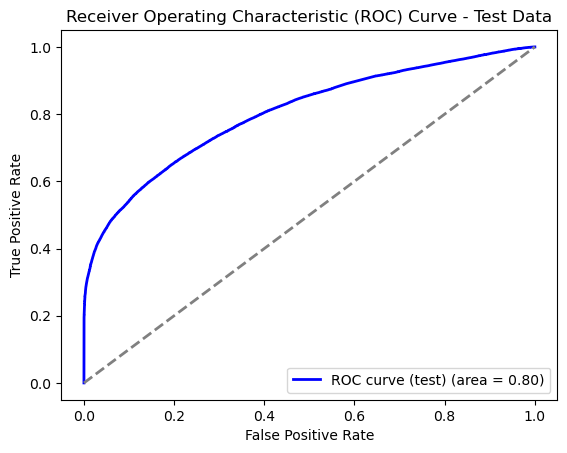

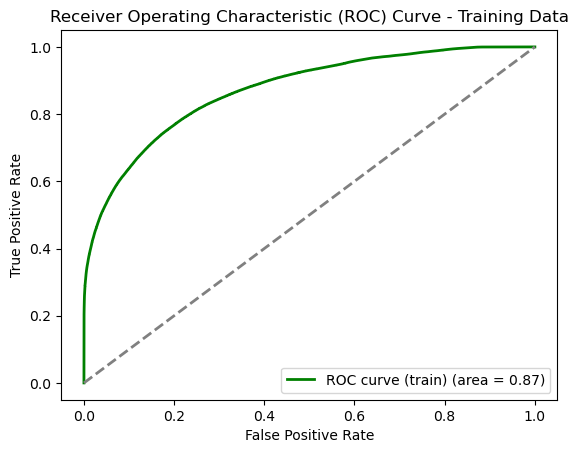

In [26]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 5, 1: 1},  
    random_state=42
)

from sklearn.metrics import confusion_matrix

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7269559578158535
Test Log Loss: 0.5117603278909306
Test ROC AUC: 0.8046051153462543
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.70      0.61     60507
           1       0.84      0.74      0.79    133784

    accuracy                           0.73    194291
   macro avg       0.70      0.72      0.70    194291
weighted avg       0.75      0.73      0.73    194291

Class 0 Test Accuracy: 0.6953245079081759
Class 1 Test Accuracy: 0.741262034323985
Train Accuracy: 0.7896003617785452
Train Log Loss: 0.45623279452037246
Train ROC AUC: 0.8796952870973095
Train Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80    535134
           1       0.81      0.75      0.78    535134

    accuracy                           0.79   1070268
   macro avg       0.79      0.79      0.79   1070268
weighted avg       0.79      0.79      0.79   1070268



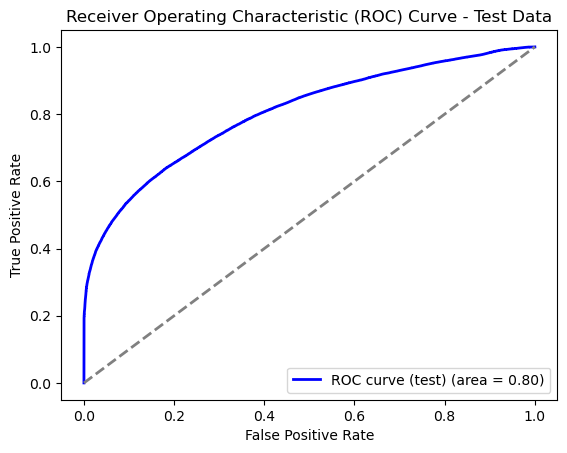

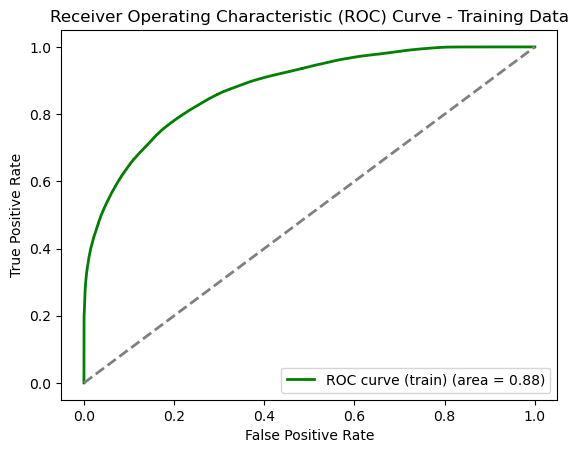

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(
    n_estimators=100,             
    max_depth=8,                  
    min_samples_split=20,         
    min_samples_leaf=10,          
    max_leaf_nodes=50,            
    class_weight='balanced',      
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5009290188428697
Test Log Loss: 0.9048317042413321
Test ROC AUC: 0.7899543864090508
Test Classification Report:
              precision    recall  f1-score   support

           0       0.38      1.00      0.55     60507
           1       0.99      0.28      0.43    133784

    accuracy                           0.50    194291
   macro avg       0.69      0.64      0.49    194291
weighted avg       0.80      0.50      0.47    194291

Class 0 Test Accuracy: 0.9957195035285173
Class 1 Test Accuracy: 0.2771482389523411
Train Accuracy: 0.6437210119334597
Train Log Loss: 0.6818381039775827
Train ROC AUC: 0.854962496660048
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74    535134
           1       0.99      0.29      0.45    535134

    accuracy                           0.64   1070268
   macro avg       0.79      0.64      0.59   1070268
weighted avg       0.79      0.64      0.59   1070268

C

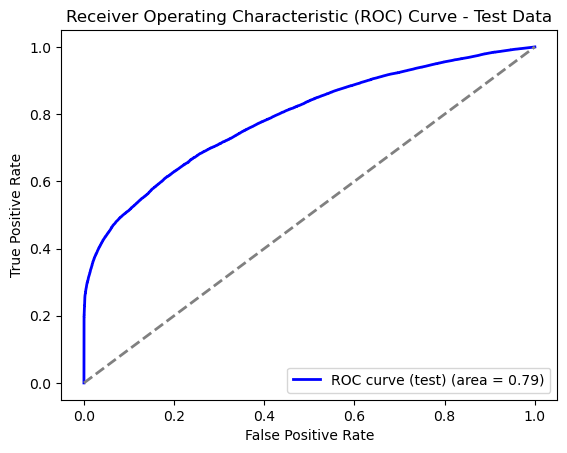

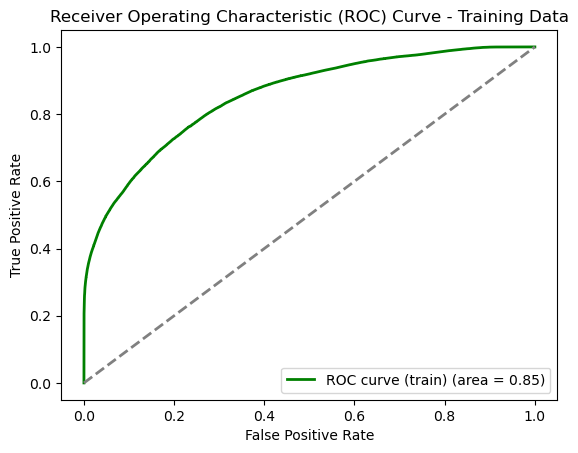

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve

model = RandomForestClassifier(
    n_estimators=50,  
    max_depth=6,     
    min_samples_split=50,
    min_samples_leaf=20,
    max_leaf_nodes=30,
    class_weight={0: 5, 1: 1},
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.5777982510769928
Test Log Loss: 0.8683915875761152
Test ROC AUC: 0.6912610730236239
Test Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.80      0.54     60507
           1       0.84      0.48      0.61    133784

    accuracy                           0.58    194291
   macro avg       0.62      0.64      0.57    194291
weighted avg       0.71      0.58      0.59    194291

Train Accuracy: 0.6562029323496544
Train Log Loss: 0.7594693999312943
Train ROC AUC: 0.7200880382659538
Train Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.82      0.71    535134
           1       0.73      0.49      0.59    535134

    accuracy                           0.66   1070268
   macro avg       0.68      0.66      0.65   1070268
weighted avg       0.68      0.66      0.65   1070268



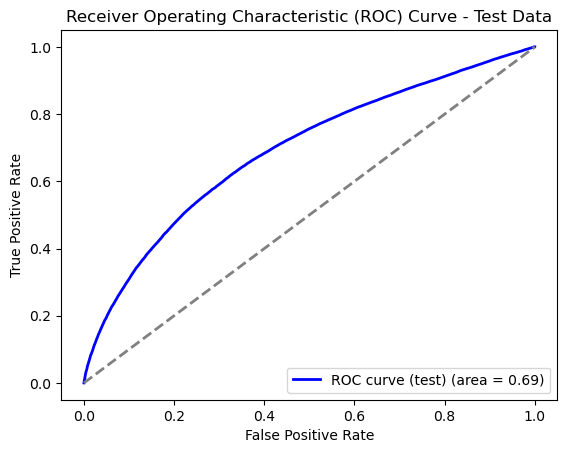

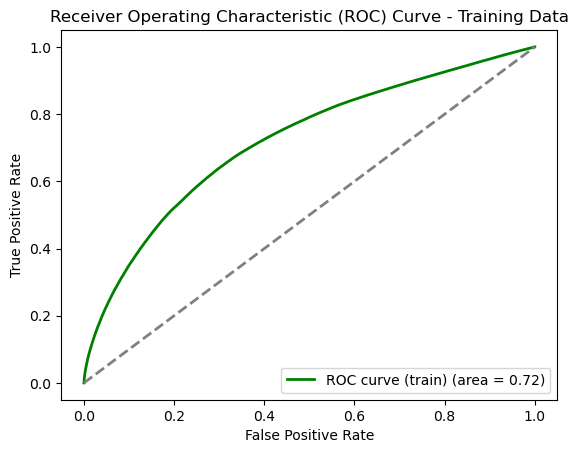

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the Naive Bayes model
model = GaussianNB() 
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7714510708164557
Test Log Loss: 0.4423630197102171
Test ROC AUC: 0.8421844330894582
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     60507
           1       0.83      0.83      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6358933677095212
Class 1 Test Accuracy: 0.8327602702864318
Train Accuracy: 0.8311067882063184
Train Log Loss: 0.34079593366783284
Train ROC AUC: 0.9258649166300048
Train Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83    535134
           1       0.83      0.83      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268


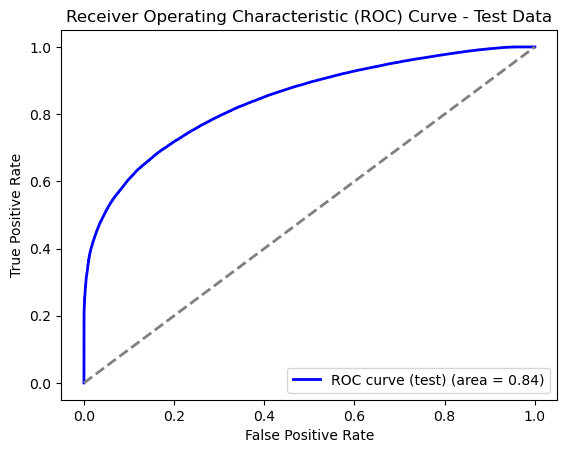

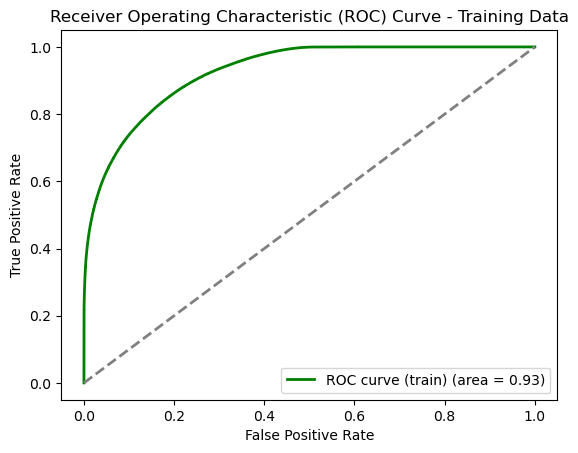

In [7]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7714510708164557
Test Log Loss: 0.4423630197102171
Test ROC AUC: 0.8421844330894582
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63     60507
           1       0.83      0.83      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6358933677095212
Class 1 Test Accuracy: 0.8327602702864318
Train Accuracy: 0.8311067882063184
Train Log Loss: 0.34079593366783284
Train ROC AUC: 0.9258649166300048
Train Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83    535134
           1       0.83      0.83      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268


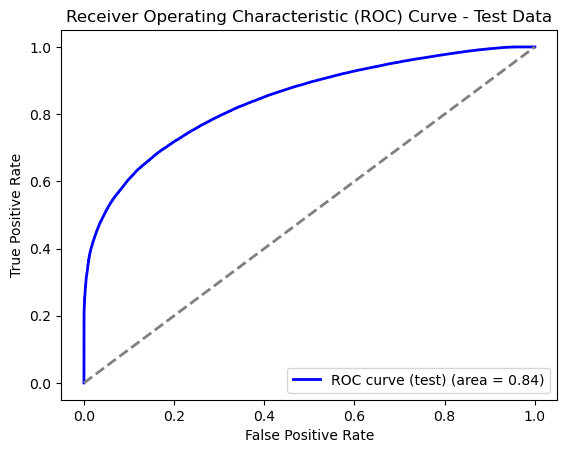

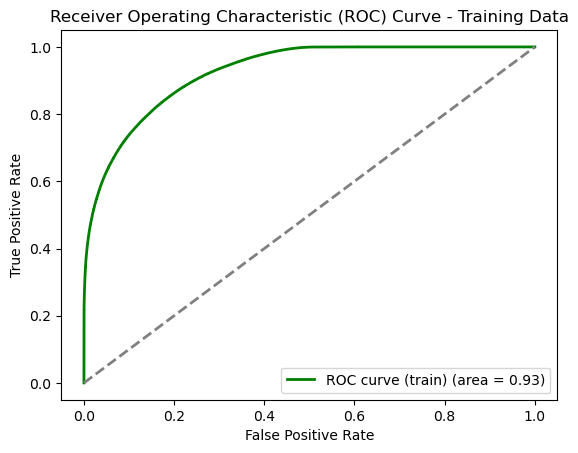

In [8]:
import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7668651661682734
Test Log Loss: 0.45222955417339006
Test ROC AUC: 0.8365373287457909
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.65      0.63     60507
           1       0.84      0.82      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6458261027649693
Class 1 Test Accuracy: 0.8216079650780362
Train Accuracy: 0.8259725601438145
Train Log Loss: 0.35428893102349435
Train ROC AUC: 0.9209077875538484
Train Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83    535134
           1       0.82      0.83      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268

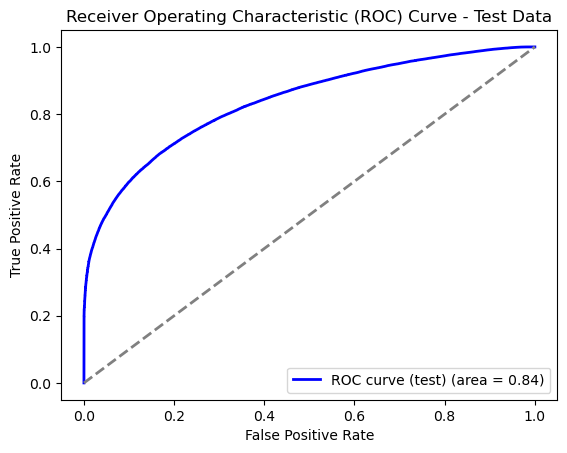

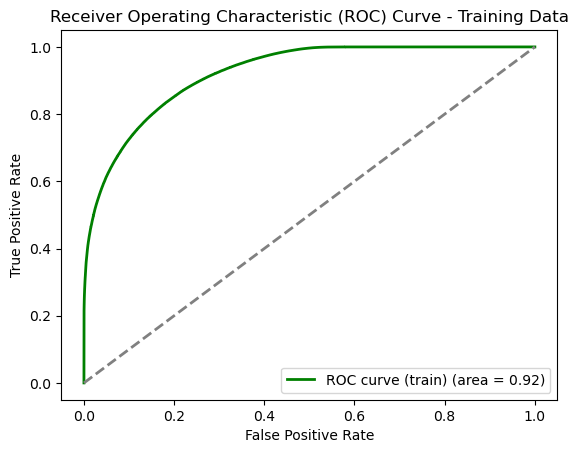

In [9]:
model = xgb.XGBClassifier(
    max_depth=5,                  
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,         
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                    
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.769572445455528
Test Log Loss: 0.4441274485448609
Test ROC AUC: 0.8411772326621645
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     60507
           1       0.83      0.83      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6312327499297602
Class 1 Test Accuracy: 0.8321398672486994
Train Accuracy: 0.8311002477884044
Train Log Loss: 0.3413793867628686
Train ROC AUC: 0.9254574091507126
Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83    535134
           1       0.83      0.84      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268

C

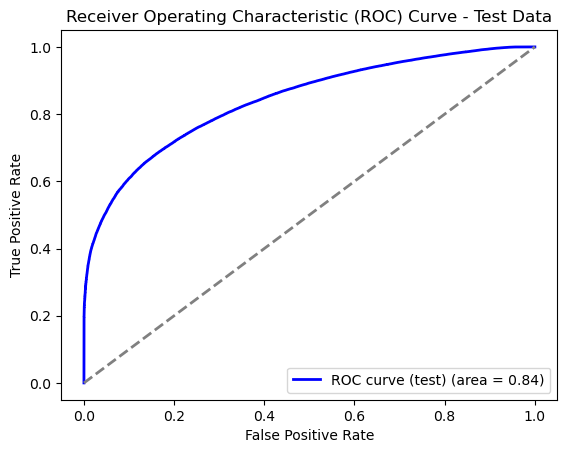

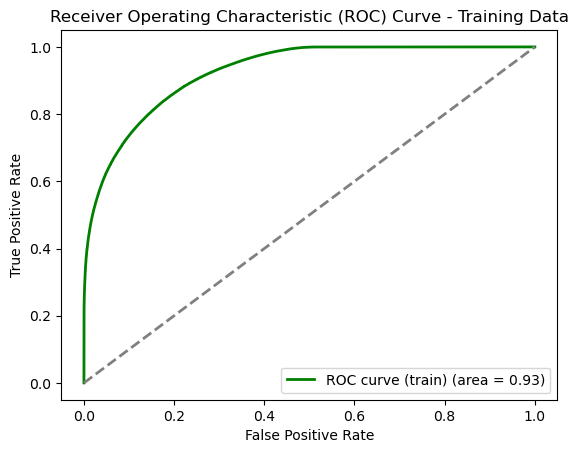

In [10]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7697989098825988
Test Log Loss: 0.4471613895200809
Test ROC AUC: 0.8400471987383817
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.63      0.63     60507
           1       0.83      0.83      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6333151536185896
Class 1 Test Accuracy: 0.8315269389463613
Train Accuracy: 0.8295408252886193
Train Log Loss: 0.34677470138634986
Train ROC AUC: 0.9242872159209713
Train Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83    535134
           1       0.83      0.83      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268


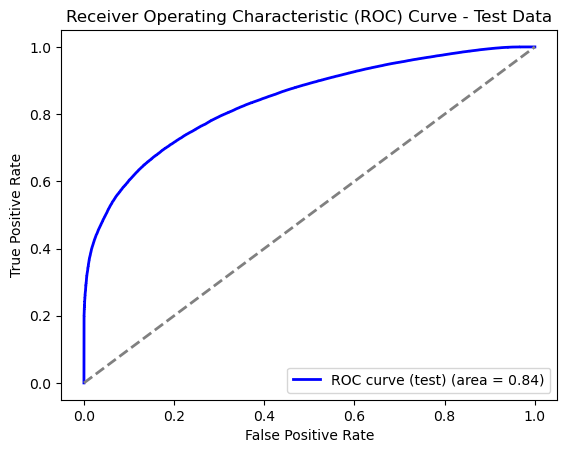

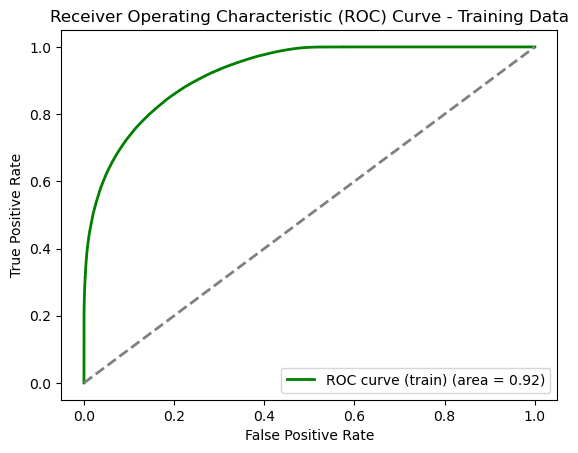

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                   
    learning_rate=0.05,             
    n_estimators=200,               
    subsample=0.8,                 
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7633961428990534
Test Log Loss: 0.46044546744752224
Test ROC AUC: 0.8314083277544162
Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63     60507
           1       0.83      0.82      0.83    133784

    accuracy                           0.76    194291
   macro avg       0.72      0.73      0.73    194291
weighted avg       0.77      0.76      0.76    194291

Class 0 Test Accuracy: 0.6409506338109641
Class 1 Test Accuracy: 0.8187750403635712
Train Accuracy: 0.8202777248315375
Train Log Loss: 0.3749660350576466
Train ROC AUC: 0.9141099157638924
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82    535134
           1       0.83      0.81      0.82    535134

    accuracy                           0.82   1070268
   macro avg       0.82      0.82      0.82   1070268
weighted avg       0.82      0.82      0.82   1070268


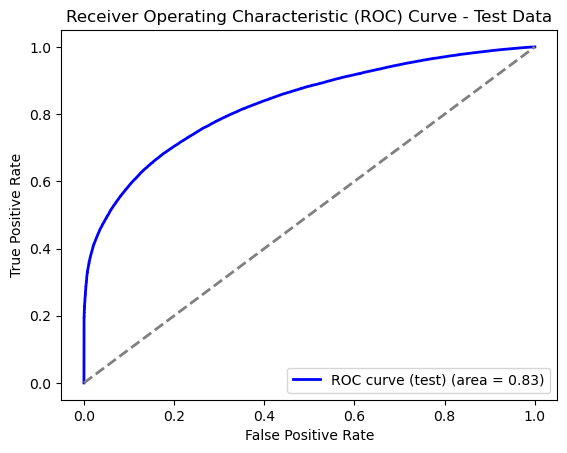

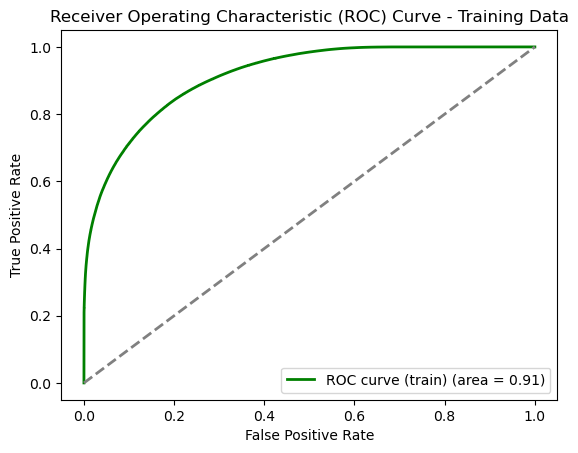

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7752700845638758
Test Log Loss: 0.44124733785427933
Test ROC AUC: 0.8429319578341741
Test Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.59      0.62     60507
           1       0.82      0.86      0.84    133784

    accuracy                           0.78    194291
   macro avg       0.74      0.73      0.73    194291
weighted avg       0.77      0.78      0.77    194291

Class 0 Test Accuracy: 0.5917497149090188
Class 1 Test Accuracy: 0.8582715421874065
Train Accuracy: 0.8356533130019771
Train Log Loss: 0.33334215803421424
Train ROC AUC: 0.9291034251669785
Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83    535134
           1       0.83      0.84      0.84    535134

    accuracy                           0.84   1070268
   macro avg       0.84      0.84      0.84   1070268
weighted avg       0.84      0.84      0.84   1070268

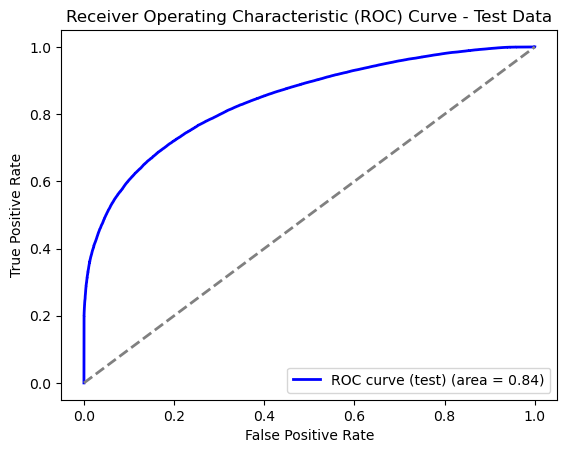

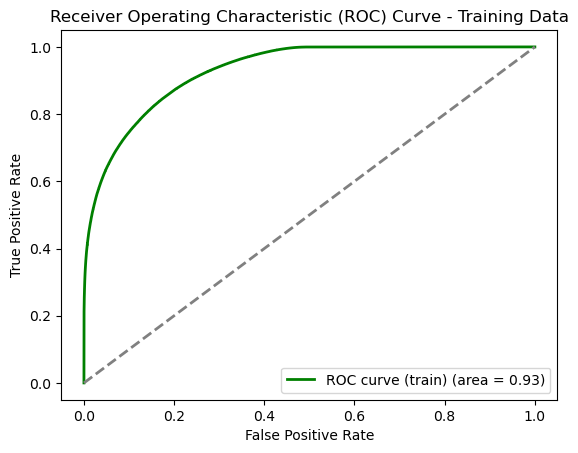

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


Test Accuracy: 0.7471524671755254
Test Log Loss: 0.47477221969920536
Test ROC AUC: 0.8421183300390142
Test Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.79      0.66     60507
           1       0.88      0.73      0.80    133784

    accuracy                           0.75    194291
   macro avg       0.73      0.76      0.73    194291
weighted avg       0.79      0.75      0.76    194291

Class 0 Test Accuracy: 0.7902226188705439
Class 1 Test Accuracy: 0.7276729653770256
Train Accuracy: 0.8110099526473743
Train Log Loss: 0.3644658741340457
Train ROC AUC: 0.9281680866348228
Train Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83    535134
           1       0.91      0.69      0.79    535134

    accuracy                           0.81   1070268
   macro avg       0.83      0.81      0.81   1070268
weighted avg       0.83      0.81      0.81   1070268


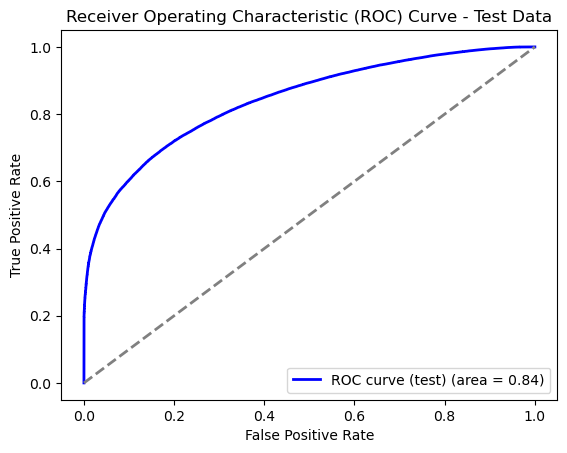

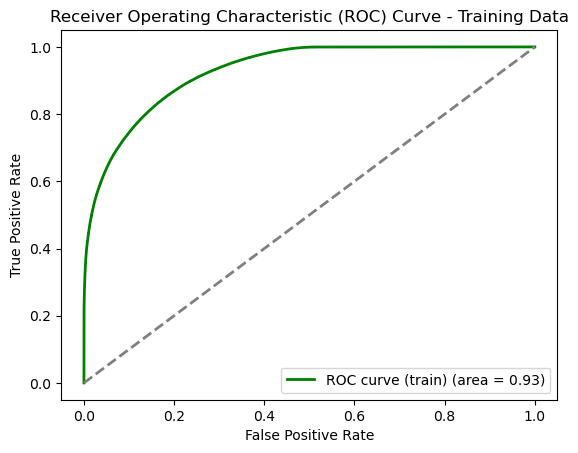

In [14]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Assign higher weight to Class 0 samples
sample_weights = [2 if y == 0 else 1 for y in y_train]
model.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy: 0.7080873535058237
Test Log Loss: 0.5669336710893778
Test ROC AUC: 0.7579482148592505
Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.56      0.54     60507
           1       0.79      0.78      0.79    133784

    accuracy                           0.71    194291
   macro avg       0.66      0.67      0.66    194291
weighted avg       0.71      0.71      0.71    194291

Class 0 Test Accuracy: 0.5565637033731634
Class 1 Test Accuracy: 0.776617532739341
Train Accuracy: 0.8409435767490012
Train Log Loss: 0.4681920732524287
Train ROC AUC: 0.9339574652825139
Train Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84    535134
           1       0.83      0.86      0.84    535134

    accuracy                           0.84   1070268
   macro avg       0.84      0.84      0.84   1070268
weighted avg       0.84      0.84      0.84   1070268

C

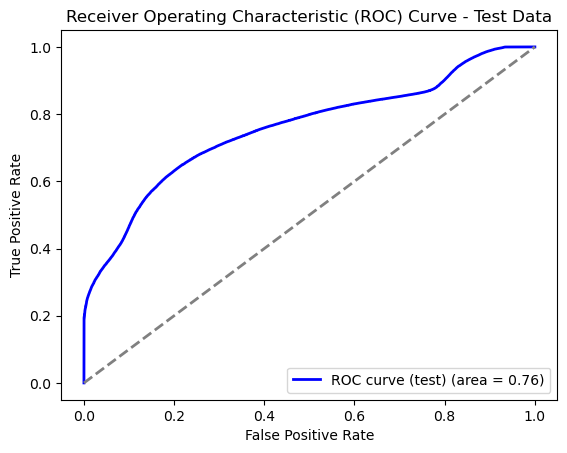

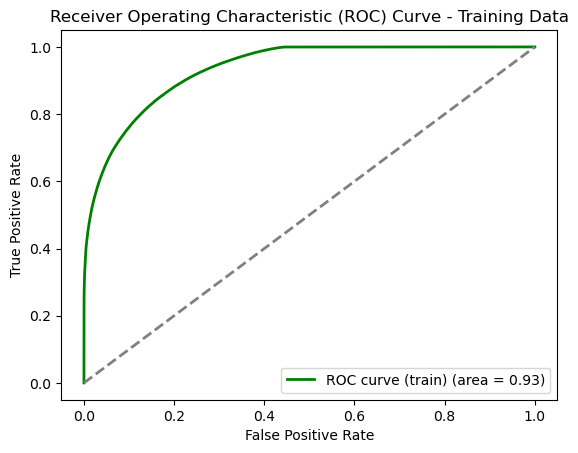

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# AdaBoost model with a DecisionTreeClassifier as the base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  
    learning_rate=0.1,                              
    n_estimators=100,                               
    random_state=42                                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7693717156224427
Test Log Loss: 0.44684540405252104
Test ROC AUC: 0.8379467250833488
Test Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.63     60507
           1       0.83      0.84      0.83    133784

    accuracy                           0.77    194291
   macro avg       0.73      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy: 0.6201431239360735
Class 1 Test Accuracy: 0.8368639000179393
Train Accuracy: 0.8297426438985376
Train Log Loss: 0.34206932769866744
Train ROC AUC: 0.9237940856349203
Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.83    535134
           1       0.82      0.85      0.83    535134

    accuracy                           0.83   1070268
   macro avg       0.83      0.83      0.83   1070268
weighted avg       0.83      0.83      0.83   1070268

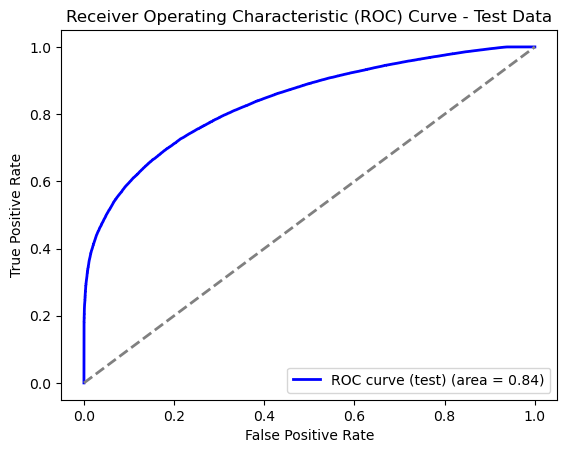

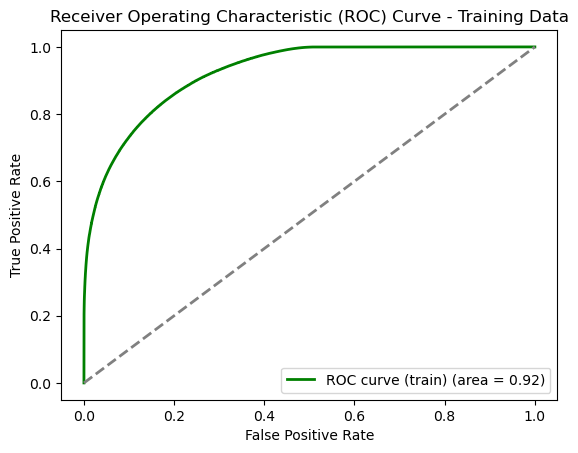

In [16]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# CatBoost model
model = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 535134, number of negative: 535134
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4926
[LightGBM] [Info] Number of data points in the train set: 1070268, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Test Accuracy: 0.7739318856766397
Test Log Loss: 0.439812877167463
Test ROC AUC: 0.8438181929855708
Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.63      0.63     60507
           1       0.83      0.84      0.84    133784

    accuracy                           0.77    194291
   macro avg       0.74      0.73      0.73    194291
weighted avg       0.77      0.77      0.77    194291

Class 0 Test Accuracy:

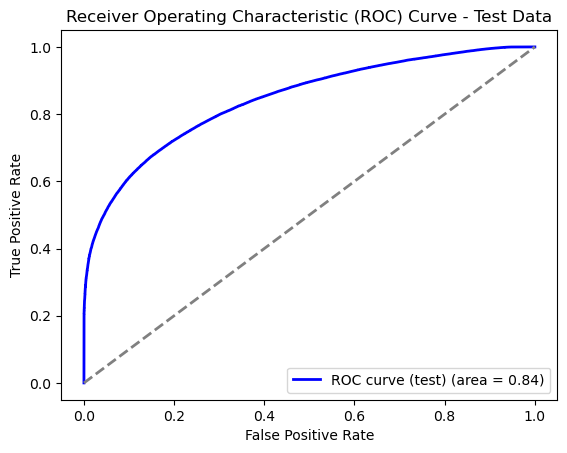

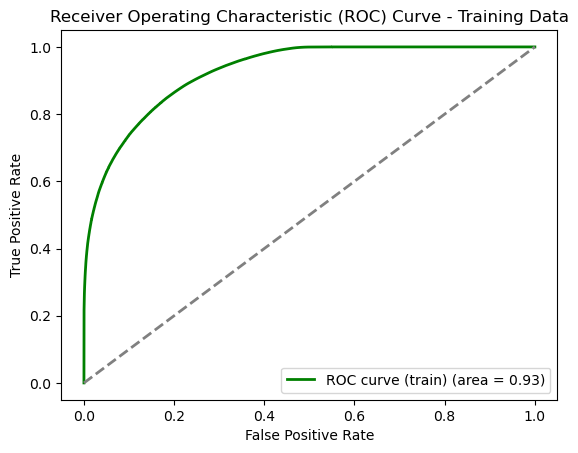

In [17]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# LightGBM model
model = LGBMClassifier(
    max_depth=6,                     
    learning_rate=0.1,               
    n_estimators=100,                
    random_state=42                  
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Initialize the model
modelxgb = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    modelxgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Use the best model for prediction
model = random_search.best_estimator_

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Convert data to numeric types
X_train_numeric = np.array(X_train, dtype=np.float32)  
X_test_numeric = np.array(X_test, dtype=np.float32)    
y_train_numeric = np.array(y_train, dtype=np.float32)  
y_test_numeric = np.array(y_test, dtype=np.float32)    

# Reshape X_train and X_test to have a time step dimension (convert to 3D for RNN input)
X_train_reshaped = np.expand_dims(X_train_numeric, axis=1)  
X_test_reshaped = np.expand_dims(X_test_numeric, axis=1)

# Define the Simple RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba) 
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt


# Define the GRU model
model = Sequential([
    GRU(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                   
    learning_rate=0.05,             
    n_estimators=200,               
    subsample=0.8,                 
    random_state=42                 
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")